# Machine Learning: Assignment 5
**黄绵秋 19307130142**

## 任务描述
- 实现`MLPNN`算法
- 通过`MLPNN`对`breast_cancer`数据集进行预测

## 数据描述
- `breast_cancer`数据集一共包含569组数据，按照恶性`malignant`和良性`benign`分为两类，分别被标注为0和1，每组数据包含30个特征
- 将特征数据和标签数据分别从`sklearn.datasets`中导出到变量`X,y`中
- `breast_cancer`数据集的一些信息如下

In [76]:
from sklearn import datasets
import numpy as np
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
print('data_size:', len(X))
print('feature_numbers:', len(X[0]))
print('target_names:',cancer.target_names)
print(cancer.DESCR)

data_size: 569
feature_numbers: 30
target_names: ['malignant' 'benign']
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each imag

## 数据描述
- 通过观察各个特征的数值大小，可以发现各个特征之间数量级差距较大，故而需要进行归一化处理

In [77]:
print(X[0])
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X=X)
print(X[0])

[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
[0.52103744 0.0226581  0.54598853 0.36373277 0.59375282 0.7920373
 0.70313964 0.73111332 0.68636364 0.60551811 0.35614702 0.12046941
 0.3690336  0.27381126 0.15929565 0.35139844 0.13568182 0.30062512
 0.31164518 0.18304244 0.62077552 0.14152452 0.66831017 0.45069799
 0.60113584 0.61929156 0.56861022 0.91202749 0.59846245 0.41886396]


- 为对回归结果进行有效评估，将数据分割成训练集和测试集两部分，其中70%为训练集，30%为测试集。

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021, shuffle=True)
print('数据集size:\n', '训练集', X_train.shape, y_train.shape, '\n 测试集', X_test.shape, y_test.shape)

数据集size:
 训练集 (398, 30) (398,) 
 测试集 (171, 30) (171,)


## `MLPNN`模型
### 模型概述
`MLPNN`模型是一种前向结构的人工神经网络，其包含一个输入层、一个或多个隐藏层和一个输出层。在前馈神经网络中，各神经元分别属于不同的层。每一层的神经元可以接收前一层神经元的信号，并产生信号输出到下一层。第0层称为输入层，最后一层称为输出层，其他中间层称为隐藏层。整个网络中无反馈，信号从输入层向输出层单向传播。每层神经元之间为全连接，通过激活函数进行处理，经过最后一层的输出层，通过激活函数进行处理，得到预测结果。

![model_description](./v2-2110a4d62384a277ab700907e73e8721_b.gif)

### 模型推导
#### 符号规定
- $L$: 神经网络的层数
- $M_l$: 第$l$层的神经元数量
- $f_l(\cdot)$: 第$l$层神经元的激活函数
- $W^{(l)}\in\mathbb{R}^{M_l\times M_{l-1}}$: 第$l-1$层神经元到第$l$层神经元的权重矩阵
- $b^{(l)}\in\mathbb{R}^{M_l}$: 第$l-1$层到第$l$层的偏置向量
- $z^{(l)}\in\mathbb{R}^{M_l}$: 第$l$层神经元的净输入（净活性值）
- $a^{(l)}\in\mathbb{R}^{M_l}$: 第$l$层神经元的输出（活性值）

#### 模型目标
为训练一个有效预测的模型，我们需要训练出$W$和$b$以使预测模型尽可能的接近真实数据。
这一过程中需要使损失函数最小化，这一过程中使用最小化损失函数的反向传播算法。

####  参数学习
多层前馈神经网络可以看作一个非线性复合函数$\phi:\ \mathbb R^D\rightarrow \mathbb R^{D'}$，将输入$x\in \mathbb R^D$映射到输出$x\in \mathbb R^{D'}$。因此，多层前馈神经网络也可以看成是一种特 征转换方法，其输出$\phi(x)$作为分类器的输入进行分类．

给定一个训练样本$(x, y)$，先利用多层前馈神经网络将$x$映射到$\phi(x)$，然后再将$\phi(x)$输入到分类器$g(\cdot)$，即
$$\hat y=g(\phi(x);\theta)$$
其中$g(\cdot)$为线性或非线性的分类器，$\theta$为分类器的参数,$\hat y$为分类器的输出。

设损失函数为$L(y,\hat y)$。给定训练集为$\mathcal D=\{(x^{(n)},y^{(n)})\}_{n=1}^N$，将每个样本$x^{(n)}$输入给`MLPNN`，得到网络输出为$\hat y^{(n)}$，其在数据集$\mathcal D$上的风险函数为
$$\mathcal R(W,b)=\frac{1}{N}\sum_{n=1}^N\mathcal L(y^{(n)}, \hat y^{(n)})$$
为了得到$\hat y^{(n)}$，我们需要通过各个隐藏层和输出层最终得到，这一过程叫做前向计算。令$a^{(0)}=x$，前馈神经网络通过不断迭代的方式进行信息传播。首先根据第$l-1$层的神经元的活性值$a^{(l-1)}$计算出第$l$层的神经元的净输入$z^{(l)}$，然后根据第$l$层的神经元的净输入$z^{(l)}$经过一个激活函数计算出第$l$层的神经元的活性值$a^{(l)}$，这一过程记为前向计算，公式如下
$$z^{(l)}=W^{(l)}f_{l-1}(z^{(l-1)})+b^{(l)}\\
a^{(l)}=f_l(W^{(l)}a^{(l-1)}+b^{(l)})$$

有了学习准则和训练样本，网络参数可以通过梯度下降的方法迭代求解，公式如下，其中$\alpha$为学习率
$$\begin{align*}W^{(l)}&\leftarrow W^{(l)}-\alpha\frac{\partial\mathcal R(W,b)}{\partial W^{(l)}}\\&=W^{(l)}-\alpha\left(\frac{1}{N}\sum_{n=1}^N\frac{\partial\mathcal L(y^{(n)}, \hat y^{(n)})}{\partial W^{(l)}}\right)\\b^{(l)}&\leftarrow b^{(l)}-\alpha\frac{\partial\mathcal R(W,b)}{\partial b^{(l)}}\\&=b^{(l)}-\alpha\left(\frac{1}{N}\sum_{n=1}^N\frac{\partial\mathcal L(y^{(n)}, \hat y^{(n)})}{\partial b^{(l)}}\right)\end{align*}$$
因而参数学习就需要计算损失函数关于每个参数的导数。不失一般性，对第$l$层中的参数$W^{(l)}$和$b^{(l)}$计算偏导数，根据链式法则，有
$$\frac{\partial\mathcal L(y,\hat y)}{\partial w_{ij}^{(l)}}=\frac{\partial z^{(l)}}{\partial w_{ij}^{(l)}}\frac{\partial \mathcal L(y,\hat y)}{\partial z^{(l)}}\\\frac{\partial\mathcal L(y,\hat y)}{\partial b^{(l)}}=\frac{\partial z^{(l)}}{\partial b^{(l)}}\frac{\partial \mathcal L(y,\hat y)}{\partial z^{(l)}}$$
问题转化成计算三个偏导数$\frac{\partial z^{(l)}}{\partial w_{ij}^{(l)}},\frac{\partial z^{(l)}}{\partial b^{(l)}},\frac{\partial \mathcal L(y,\hat y)}{\partial z^{(l)}}$，经过计算不难得到

- 计算$\frac{\partial z^{(l)}}{\partial w_{ij}^{(l)}}$
  
  因为$z^{(l)}=W^{(l)}a^{(l-1)}+b^{(l)}$，偏导数$\frac{\partial z^{(l)}}{\partial w_{ij}^{(l)}}=\mathbb{I}_i(a_j^{(l-1)})\in\mathbb R^{1\times M_l}$

- 计算$\frac{\partial z^{(l)}}{\partial b^{(l)}}$
  
  因为$z^{(l)}=W^{(l)}a^{(l-1)}+b^{(l)}$，偏导数$\frac{\partial z^{(l)}}{\partial b^{(l)}}=\mathbf{I}_{M_l}\in\mathbb R^{M_l\times M_l}$

- 计算$\frac{\partial \mathcal L(y,\hat y)}{\partial z^{(l)}}$

  偏导数$\frac{\partial \mathcal L(y,\hat y)}{\partial z^{(l)}}$表示第$l$层神经元对最终损失的影响，也反映了最终损失对第$l$层神经元的影响程度，因此一般称为第$l$层神经元的`误差项`，用$\delta^{(l)}$来表示

  根据$z^{(l+1)}=W^{(l+1)}a^{(l)}+b^{(l+1)}$，有
  $$\frac{\partial z^{(l+1)}}{\partial a^{(l)}}=(W^{(l+1)})^T\in\mathbb R^{M_l\times M_{l+1}}$$
  根据$a^{(l)}=f_l(z^{(l)}$，其中$f_l(\cdot)$为按位计算的函数，因此有
  $$\frac{\partial a^{(l)}}{\partial z^{(l)}}=\frac{\partial f_l(z^{(l)})}{\partial z^{(l)}}=diag(f_l'(z^{(l)}))\in\mathbb R^{M_l\times M_{l}}$$
  因此，根据链式法则，第$l$层的误差项为
  $$\begin{align*}\delta^{(l)}&\triangleq\frac{\partial \mathcal L(y,\hat y)}{\partial z^{(l)}}\\&=\frac{\partial a^{(l)}}{\partial z^{(l)}}\cdot\frac{\partial z^{(l+1)}}{\partial a^{(l)}}\cdot\frac{\partial \mathcal L(y,\hat y)}{\partial z^{(l+1)}}\\&=diag(f_l'(z^{(l)}))\cdot(W^{(l+1)})^T\cdot\delta^{(l+1)}\end{align*}$$

从公式可以看出，第$l$层的误差项可以通过第$l+1$层的误差项计算得
到，这就是误差的`反向传播`（BackPropagation，BP）。反向传播算法的含义是：第$l$层的一个神经元的误差项（或敏感性）是所有与该神经元相连的第$l+1$层 的神经元的误差项的权重和，然后，再乘上该神经元激活函数的梯度。

计算出上面三个偏导数后，可以得到
$$\begin{align*}\frac{\partial\mathcal L(y,\hat y)}{\partial w_{ij}^{(l)}}&=\mathbf I_i(a_j^{(l-1)})\delta^{(l)}\\&=\delta^{(l)}_ia_j^{(l-1)}\end{align*}$$
进一步可有
$$\frac{\partial\mathcal L(y,\hat y)}{\partial W^{(l)}}=\delta^{(l)}(a^{(l-1)})^T\in\mathbb R^{M_l\times M_{l-1}}$$
同理有
$$\frac{\partial\mathcal L(y,\hat y)}{\partial b^{(l)}}=\delta^{(l)}\in\mathbb R^{M_l}$$
在计算出每一层的误差项之后，我们就可以得到每一层参数的梯度．因此， 使用误差反向传播算法的前馈神经网络训练过程可以分为以下三步：
1. 前馈计算每一层的净输入$z^{(l)}$和激活值$a^{(l)}$，直到最后一层；
2. 反向传播计算每一层的误差项$\delta^{(l)}$；
3. 计算每一层参数的偏导数，并更新参数。

### 模型实现

In [79]:
class Hyperparam(object):
    def __init__(self, input_size, hidden_size, output_size, max_epoch=1000, batch_size=100, epsilon=0.0001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.epsilon = epsilon

    def toString(self):
        return 'input_size: %d, output_size: %d, max_epoch: %d, batch_size: %d, epsilon: %f' % (self.input_size, self.output_size, self.max_epoch, self.batch_size, self.epsilon)

In [80]:
class Layer(object):
    def __init__(self, input_size, output_size, activation, lr=0.01):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        self.lr = lr
        self.W = np.random.randn(input_size, output_size)
        self.b = np.zeros((1, output_size))
        self.z = np.zeros((1, output_size))
        self.a = np.zeros((1, output_size))

    def forward(self, x):
        self.z = np.dot(x, self.W) + self.b
        self.a = self.activation.forward(self.z)
        self.input = x
        return self.a
    
    def backward(self, x, grad_a):
        dz = self.activation.backward(self.z, grad_a)
        m = self.input.shape[0]
        dW = np.dot(self.input.T, dz) / m
        db = np.sum(dz, axis=0) / m
        self.dW = dW
        self.db = db
        delta_out = np.dot(dz, self.W.T)
        return delta_out

    def toString(self):
        return 'input_size: %d, output_size: %d, lr: %f' % (self.input_size, self.output_size, self.lr)

    def update(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db

class MLPNN(object):
    def __init__(self, hp, loss_func, layers):
        self.hp = hp
        self.loss_func = loss_func
        self.layers = layers

    def forward(self, X):
        input = X
        for layer in self.layers:
            input = layer.forward(input)
        self.output = input
        return self.output

    def backward(self, X, y):
        grad_a = self.loss_func.backward(self.output, y)
        for layer in reversed(self.layers):
            grad_a = layer.backward(X, grad_a)
        return grad_a

    def update(self):
        for layer in self.layers:
            layer.update()
    
    def train(self, X, y, log=False):
        if log:
            loss_log = []
        for iteration in range(self.hp.max_epoch):
            for i in range(0, len(X), self.hp.batch_size):
                X_batch = X[i:i+self.hp.batch_size]
                y_batch = y[i:i+self.hp.batch_size]
                self.forward(X_batch)
                self.backward(X_batch, y_batch)
                self.update()
            # print('epoch:', iteration, 'loss:', self.loss_func.loss(self.output, y_batch))
            if log:
                loss_log.append(self.loss_func.loss(self.output, y_batch))
        if log:
            return loss_log

    def predict(self, X):
        return self.forward(X)

    def print(self):
        print('layer0: input layer\n\r'+layers[0].toString())
        for i in range(1, len(layers)-1):
            print('layer'+str(i)+': hidden layer\n\r'+layers[i].toString())
        print('layer'+str(len(layers)-1)+': output layer\n\r'+layers[-1].toString())


class locc_func(object):
    def __init__(self, type='cross'):
        if type == 'cross':
            self.loss = self.__cross_entropy
            self.backward = self.__cross_entropy_backward
        elif type == 'mse':
            self.loss = self.__mean_squared_error
            self.backward = self.__mean_squared_error_backward
        else:
            raise Exception('unknown loss fuction type')
    
    def __cross_entropy(self, z, y):
        return -np.sum(y * np.log(z)+(1-y)*np.log(1-z))

    def __cross_entropy_backward(self, z, y):
        return -y/z + (1-y)/(1-z)

    def __mean_squared_error(self, z, y):
        return np.sum((z-y)**2)

    def __mean_squared_error_backward(self, z, y):
        return (z-y)

class sigmoid_func(object):
    def __init__(self):
        self.forward = self.__sigmoid
        self.backward = self.__sigmoid_backward
        self.__result = None
    
    def __sigmoid(self, z):
        self.__result = 1.0 / (1.0 + np.exp(-z))
        return self.__result

    def __sigmoid_backward(self, z, grad_a):
        return grad_a * self.__result * (1 - self.__result)

class relu_func(object):
    def __init__(self):
        self.forward = self.__relu
        self.backward = self.__relu_backward
    
    def __relu(self, z):
        return np.maximum(0, z)

    def __relu_backward(self, z, grad_a):
        return grad_a * (z > 0)

In [81]:
def score(test_result, y_test):
    counter = 0
    acc = 0
    for (pred_label, true_label) in zip(test_result, y_test):
        counter += 1
        if pred_label == true_label:
            acc += 1
    return acc/counter

#### 模型结果
以上便是`MLPNN`的模型实现，接下来会据此设计一个具有1个输入层、2个隐藏层和1个输出层的`MLPNN`，并使用进行训练。

(398, 1)
cross test accuracy: 0.9532163742690059
mse test accuracy: 0.9532163742690059


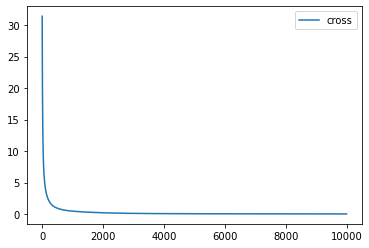

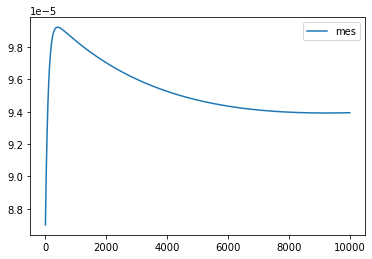

In [82]:
import matplotlib.pyplot as plt
np.random.seed(2021)
layers = []
layers.append(Layer(input_size=X_train.shape[1], output_size=50, activation=sigmoid_func(), lr=0.1))
layers.append(Layer(input_size=50, output_size=50, activation=sigmoid_func(), lr=0.1))
layers.append(Layer(input_size=50, output_size=10, activation=sigmoid_func(), lr=0.1))
layers.append(Layer(input_size=10, output_size=1, activation=sigmoid_func(), lr=0.1))
y_train = y_train.reshape(y_train.shape[0],1)
hp=Hyperparam(input_size=X_train.shape[1], hidden_size=2, output_size=1, batch_size=50, max_epoch=10000)
mlpnn = MLPNN(hp=hp, loss_func=locc_func('cross'), layers=layers)
print(y_train.shape)
cross_loss = mlpnn.train(X_train, y_train, log=True)
test_result = mlpnn.predict(X_test).reshape(y_test.shape).round()
print('cross test accuracy:', score(test_result, y_test))
mlpnn = MLPNN(hp=hp, loss_func=locc_func('mse'), layers=layers)
mes_loss = mlpnn.train(X_train, y_train, log=True)
test_result = mlpnn.predict(X_test).reshape(y_test.shape).round()
print('mse test accuracy:', score(test_result, y_test))
plt.plot(cross_loss, label='cross')
plt.legend()
plt.show()
plt.plot(mes_loss, label='mes')
plt.legend()
plt.show()


经过`MLPNN`的训练后，在测试集中的准确率为`0.9532`，是较为成功的，认为模型实现成功。值得注意的是，采用了小批量梯度下降进行了10000次迭代，交叉熵损失已经收敛，均方差损失的损失一直很小，先上升后下降，在8000次迭代之后逐渐收敛，这表明学习率太小，需要增大以加快学习速度。

### 模型优化
由于我们的样本容量较小，很可能会出现过拟合现象，所以我们需要引入正则化，使结构风险最小化。此时损失函数为
$$\mathcal R(W,b)=\frac{1}{N}\sum_{n=1}^N\mathcal L(y^{(n)},\hat y^{(n)})+\frac{1}{2}\lambda||W||_F^2$$
其中$||W||_F^2$是正则化项，用来防止过拟合，$\lambda>0$是正则化系数，$\lambda$越大，正则化项越强，$W$越接近0。这里的$||W||_F^2$我们使用`Frobenius`范数，即求$W$的Frobenius范数，即$||W||_F^2=\sum_{l=1}^L\sum_{i=1}^{M_l}\sum_{j=1}^{M_{l-1}}(w_{ij}^{(l)})^2$。据此我们更新$W$和$b$的参数更新方式：
$$\begin{align*}W^{(l)}&\leftarrow W^{(l)}-\alpha\frac{\partial\mathcal R(W,b)}{\partial W^{(l)}}\\&=W^{(l)}-\alpha\left(\frac{1}{N}\sum_{n=1}^N\frac{\partial\mathcal L(y^{(n)}, \hat y^{(n)})}{\partial W^{(l)}}+\lambda W^{(l)}\right)\\b^{(l)}&\leftarrow b^{(l)}-\alpha\frac{\partial\mathcal R(W,b)}{\partial b^{(l)}}\\&=b^{(l)}-\alpha\left(\frac{1}{N}\sum_{n=1}^N\frac{\partial\mathcal L(y^{(n)}, \hat y^{(n)})}{\partial b^{(l)}}\right)\end{align*}$$

In [83]:
class NormLayer(Layer):
    def __init__(self, input_size, output_size, activation=None, lr=0.01, lamda=0.001):
        super().__init__(input_size, output_size, activation, lr)
        self.lamda = lamda

    def update(self):
        self.W -= self.lr * self.dW + self.lamda * self.W
        self.b -= self.lr * self.db

(398, 1)
cross test accuracy: 0.9649122807017544
mse test accuracy: 0.9473684210526315


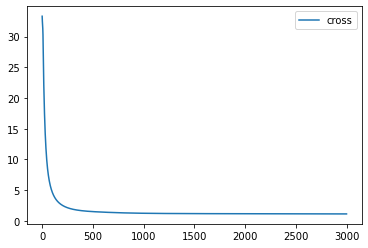

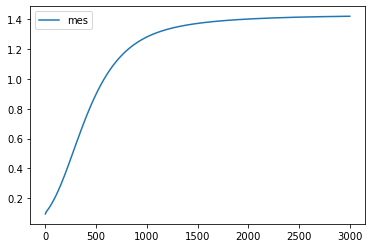

In [84]:
layers = []
layers.append(NormLayer(input_size=X_train.shape[1], output_size=50, activation=sigmoid_func(), lamda=0.0001, lr=0.1))
layers.append(NormLayer(input_size=50, output_size=50, activation=sigmoid_func(), lamda=0.0001, lr=0.1))
layers.append(NormLayer(input_size=50, output_size=10, activation=sigmoid_func(), lamda=0.0001, lr=0.1))
layers.append(NormLayer(input_size=10, output_size=1, activation=sigmoid_func(), lamda=0.0001, lr=0.1))
y_train = y_train.reshape(y_train.shape[0],1)
hp=Hyperparam(input_size=X_train.shape[1], hidden_size=2, output_size=1, batch_size=50, max_epoch=3000)
mlpnn = MLPNN(hp=hp, loss_func=locc_func('cross'), layers=layers)
print(y_train.shape)
cross_loss = mlpnn.train(X_train, y_train, log=True)
test_result = mlpnn.predict(X_test).reshape(y_test.shape).round()
print('cross test accuracy:', score(test_result, y_test))
mlpnn = MLPNN(hp=hp, loss_func=locc_func('mse'), layers=layers)
mes_loss = mlpnn.train(X_train, y_train, log=True)
test_result = mlpnn.predict(X_test).reshape(y_test.shape).round()
print('mse test accuracy:', score(test_result, y_test))
plt.plot(cross_loss, label='cross')
plt.legend()
plt.show()
plt.plot(mes_loss, label='mes')
plt.legend()
plt.show()

可以看出在引入正则化后，`MSE`损失函数的梯度下降过程变得更加清晰，更加简洁，更加稳定，也更快达到收敛；交叉熵损失函数的收敛也被加快了。正确率也依然维持在了一个很高的水平。

## 总结
通过训练多层感知器模型，对`breast_cancer`数据集进行了性能优秀的二分类。为防止过拟合问题，采用了归一化的方式进行数据预处理，引入正则化和结构模型最小化以使模型更稳定，得到了较为准确的分类结果。最终分类的准确率达到0.96左右。